In [2]:
import alborexConfig

In [3]:
datadir = "/home/ctroupin/Data/Alborex/"
figdir = "/home/ctroupin/Publis/201703_AlborexData/figures/Thermosal/HR/"
datafile = os.path.join(datadir, "RV/dep0015_socib-rv_scb-tsl001_L1_2014-05-25_HR.nc")
ctdfile = os.path.join(datadir, "CTD/dep0007_socib-rv_scb-sbe9002_L1_2014-05-25.nc")
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [5]:
m = Basemap(llcrnrlon=-1, llcrnrlat=36.5999, 
            urcrnrlon=-.3, urcrnrlat=37.2, 
            projection='merc', resolution='c')

In [6]:
color1 = "#6C92EE"
color2 = "#43D26A"
NN = -400

## CTD

In [7]:
ctd = alborexdata.CTD()
ctd.get_from_netcdf(ctdfile)

## Thermosal

In [8]:
with netCDF4.Dataset(datafile, "r") as nc:
    lon = nc.variables["LON"][:]
    lat = nc.variables["LAT"][:]
    time = nc.variables["time"][:]
    timeunits = nc.variables["time"].units
    temperature = nc.variables["WTR_TEM"][:]
    salinity = nc.variables["SALT"][:]
dates = netCDF4.num2date(time, timeunits)

In [9]:
time[1] - time[0]

10.0

In [10]:
temperature = np.ma.masked_greater(temperature, 22., copy=True)
salinity = np.ma.masked_less(salinity, 35., copy=True)

# Make the plots
## All on the same plot

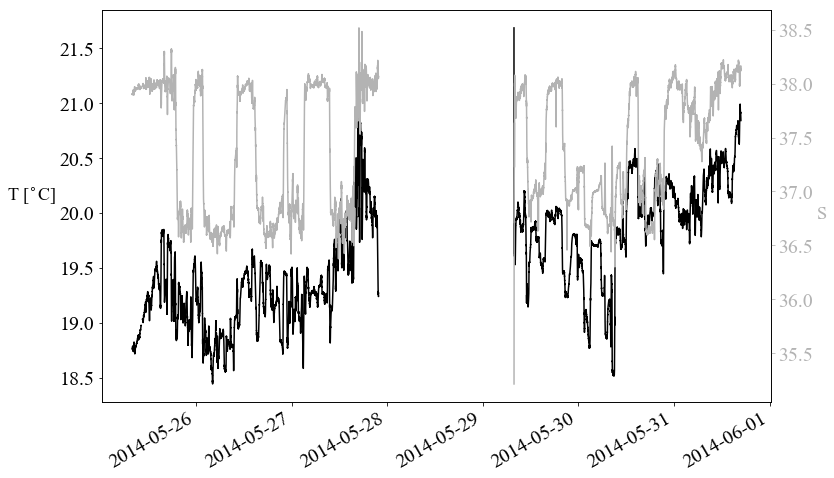

In [11]:
color1 = "k"
color2 = ".7"
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(111)
plt.plot(dates, temperature, color=color1)
plt.ylabel("T [$^{\circ}$C]", rotation=0, ha="right", fontsize=18, color=color1)
ax1.tick_params('y', colors=color1)
ax2 = ax1.twinx()
ax2.plot(dates, salinity, color=color2)
plt.ylabel("S", rotation=0, ha="left", fontsize=18, color=color2)
ax2.tick_params('y', colors=color2)
fig.autofmt_xdate()
plt.savefig(os.path.join(figdir, "thermosal_timeseries_V2.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Various subplots
Try to delimit the different tracks (hard-coded, not very clever for the moment).

In [12]:
N1 = [3650, 5020, 13945, 15000, 17200]
N2 = [4585, 5620, 14620, 15800, 18470]

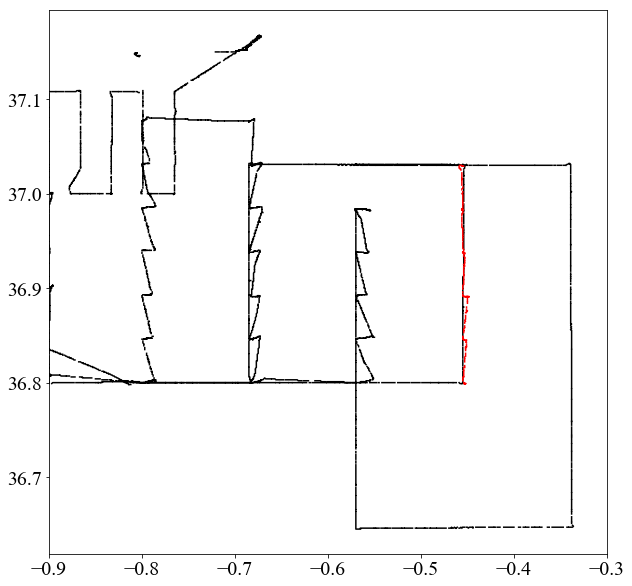

In [13]:
fig = plt.figure(figsize=(10, 10))
N1, N2 = 17200, 18470
NN = -97 * 400
plt.plot(lon[600:NN], lat[600:NN], 'k')
plt.plot(lon[N1:N2], lat[N1:N2], 'r')
#plt.plot(ctd.lon, ctd.lat, "ko")
plt.xlim(-.9, -.3)
plt.show()
plt.close()

In [14]:
N1 = [3650, 5020, 13945, 15000, 17200]
N2 = [4585, 5620, 14620, 15800, 18470]

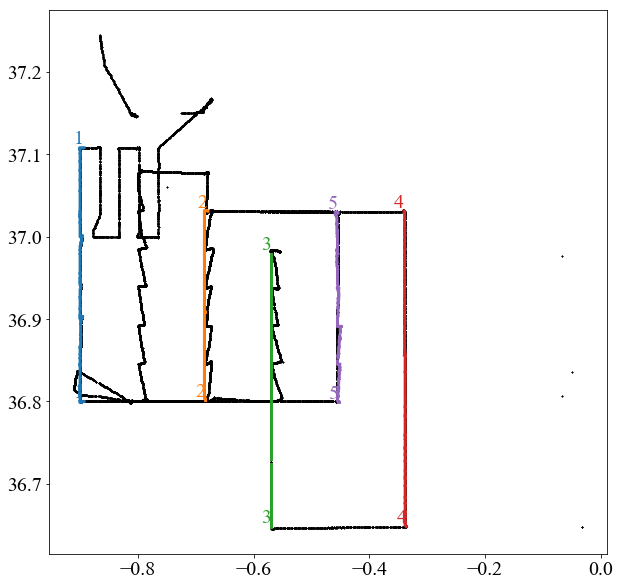

In [15]:
fig = plt.figure(figsize=(10, 10))
i = 0
for nn1, nn2 in zip(N1, N2):
    i += 1
    p = plt.plot(lon[nn1:nn2], lat[nn1:nn2], lw=3, zorder=3)
    pc = p[0].get_color()
    plt.text(lon[nn1], lat[nn1], str(i), va="bottom", ha="right", color=pc)
    plt.text(lon[nn2-1], lat[nn2-1], str(i), va="bottom", ha="right", color=pc)
    plt.plot(lon[:NN], lat[:NN], 'ko-', ms=.5, lw=.2, zorder=2)
    plt.savefig(os.path.join(figdir, "thermosal_tracks.png"), dpi=300, bbox_inches='tight')
plt.show()

## Add distance bar 

In [19]:
def get_lat_distref(ax, lon, distref=10., center=.5):
    xmin, xmax = ax.get_xlim()
    xcenter = xmin + center * (xmax - xmin)
    xdiff = xmax - xmin
    dist = vincenty((xmin, lon), (xmax, lon))
    aa = xcenter - xdiff * (distref / dist.kilometers) / 2
    bb = xcenter + xdiff * (distref / dist.kilometers) / 2
    return aa, bb

## Using Basemap

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4771: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4776: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basem

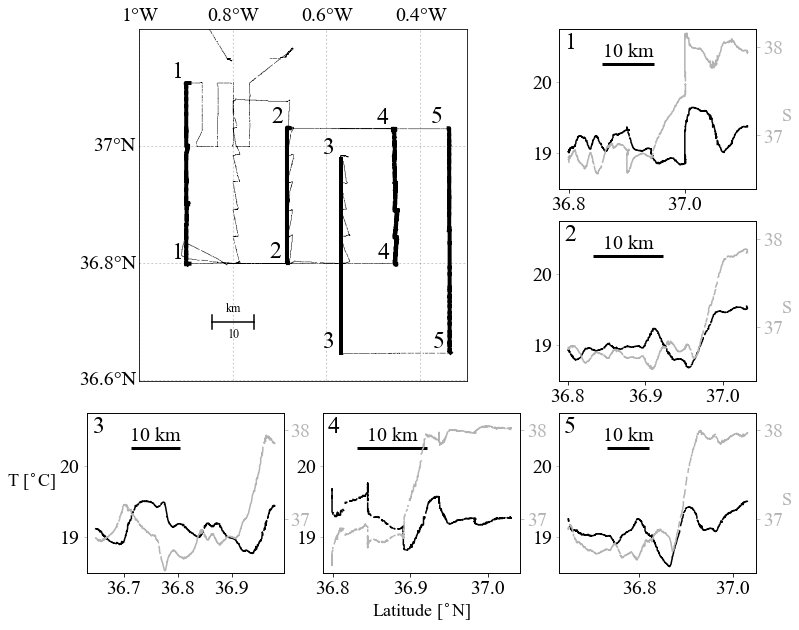

In [34]:
plt.figure(figsize=(12, 10))
axloc = ( (0, 2), (1, 2), (2, 0), (2, 1), (2, 2))

# Main map with tracks
ax = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=2)
i = 0
Nind = [0, 1, 2, 4, 3]
Nax = len(Nind)
for nn in Nind:
    i += 1
    m.plot(lon[N1[nn]:N2[nn]], lat[N1[nn]:N2[nn]], lw=4, zorder=3, color='k', latlon=True)
    xt, yt = m(lon[N1[nn]], lat[N1[nn]])
    plt.text(xt, yt, str(i) + ' ', va="bottom", ha="right", color='k', fontsize=24)
    xt, yt = m(lon[N2[nn]-1], lat[N2[nn]-1])
    plt.text(xt, yt, str(i) + ' ', va="bottom", ha="right", color='k', fontsize=24)
m.plot(lon[:NN], lat[:NN], 'k-', ms=.5, lw=.5, zorder=2, latlon=True)
m.drawparallels(np.arange(36.6, 37.201, 0.2), labels=[1, 0, 0, 0], linewidth=.2)
m.drawmeridians(np.arange(-1., -0.3, 0.2), labels=[0, 0, 1, 0], linewidth=.2)
m.drawmapscale(-.8, 36.7, .8, 36.7, 10, barstyle='simple', units='km', fontsize=12)

# Subplots
for i, nn in enumerate(Nind):
    ax = plt.subplot2grid((3, 3), axloc[i], rowspan=1, colspan=1)
    ax.plot(lat[N1[nn]:N2[nn]], temperature[N1[nn]:N2[nn]], "-", color=color1)
    aa, bb = get_lat_distref(ax, np.nanmean(lon[N1[nn]:N2[nn]]), distref=10., center=.35)
    ax.hlines(20.25, aa, bb, colors='k', linestyles='solid', label='10 km', linewidth=3)
    plt.text(.5  * (aa + bb), 20.35, "10 km", ha="center")
    plt.text(.025, .98, str(i+1), transform=ax.transAxes, 
             color='k', fontsize=24, ha='left', va='top')
    if i > Nax:
        ax.set_yticklabels(" ")
    if i == 2:
        ax.set_ylabel("T [$^{\circ}$C]", rotation=0, ha="right", fontsize=18, color=color1)
    if i == 3:
        ax.set_xlabel("Latitude [$^{\circ}$N]", fontsize=18, color=color1)
    ax.set_ylim(18.5, 20.75)
    ax.tick_params('y', colors=color1, color=color2)
    ax2 = ax.twinx()
    ax2.plot(lat[N1[nn]:N2[nn]], salinity[N1[nn]:N2[nn]], "-", color=color2)
    if i > Nax:
        ax2.set_yticklabels(" ")
    if i in (0, 1, 4):
        ax2.set_ylabel("S", rotation=0, fontsize=18, color=color2)
    ax2.set_ylim(36.4, 38.2)
    ax2.tick_params('y', colors=color2)
plt.savefig(os.path.join(figdir, "thermosal_timeseries_V8.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()